# Skye and Drew's Excellent Adventure
## Predictive Maintenance of Hydraulic Pumps with Industrial Applications


<img src="./images/NTT-Sept-17.png"></img>
## Overview / Business Problem

The stakeholder is a hydroponic farming start-up called Square Roots. The start-up spends a considerable amount of time and resources to maintain/monitor their irrigation systems. Square Roots is seeking to future proof their irrigation systems by monitoring the operation of mechanical components through various sensor data. This project will provide Square Roots with recommendations regarding which sensors provide the best predictive data for understanding the maintenance condition of their hydraulic pumps. By implementing these recommendations, Square Roots will be able to efficiently recognize the characteristics that imply an issues and in-turn, troubleshoot before any faults take place.

This project utilizes a data set which includes sensor data from 17 separate sensors collected over 2205 60-second hydraulic pump cycles. The pump condition was recorded for each 60-second cycle. The data set include five different target variables – cooler condition, valve condition, internal pump leakage, hydraulic accumulator (hydraulic pressure), and stable flag (stable condition). Although dependent on the target variable being utilized, a false positive with this data set generally implies an issue with the pump was predicted when there was no issue. In turn, a false negative implies no issues with the pump were predicted when there was in fact an issue. With regards to our stakeholder, Square Roots, a false negative would be more detrimental. Given the multiple target variables and multiple classes within a majority of these variables, the modeling performed within this analysis focuses on optimizing accuracy, the weighted F-1 score, and ROC-AUC score.

## Data Understanding
<p>
<a href="https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems#">**This data**</a> comes from a set of sensor measurements taken during 2205 sixty second cycles of a hydraulic pump testing rig. During the testing the pump's maintenance status was recorded. These various metrics of the test rigs physical condition will be the target variable for our tests. The sensor data will be the predictors.

The goal will be to use sensor data (such as temperature, tank pressure, vibration magnitude, etc.) to
predict the state of the hydraulic pump.

The data is split between sensors. Each sensor has a specific sample rate qhich cooresponds to the columns
in its table. So `TS1.txt` contains temprature readings from one sensor. Its sample rate was 1hz for
each 60 second pump cycle. Therefore, in the `TS1.txt` file there are 60 columns and 2205 rows of data.
 
### Structure of the Data
**The structure of the data is this:**
1. The rows represent 1 cycle of the hydraulic test rig.
2. The individual txt files are sensor readings, rows represent a cycle, each column is a reading
   from that specific sensor.
3. Readings from each table are given in hz, and each cycle lasted 60 seconds. So, a 1hz sensor
   provides a 60 column by 2205 row table.
4. "Profile.txt" contains a 5 column by 2205 row table with system states encoded in each column.

### Target Variables
**Now that we can see the structure** of our target variables a little more clearly lets take a
look at the `profile.txt` file in our dataset. 

I will pull it inot a primary DataFrame object, so that we can continue to work with it; adding 
predictor variables and iterating over a test pipeline to find the best combinations for prediction.

Setting this up just requires pulling in the five columns and assigning column names based on our
encoding keys from the above dictionary.

In [1]:
#Import all necessary libraries
from glob import iglob
from joblib import load, dump
import os
import pickle
from tabulate import tabulate
from typing import Union, BinaryIO
from time import perf_counter

from IPython.display import display, HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (plot_confusion_matrix, accuracy_score, recall_score,
                             precision_score, f1_score, roc_auc_score, plot_roc_curve, 
                             confusion_matrix, roc_curve)


In [2]:
run -i "./helper.py"

In [3]:
run "./RegularModel.py"

In [4]:
conf_m_colors = sns.cubehelix_palette(start=2, gamma=.5, dark=.4, light=1, hue=2, rot=1, as_cmap=True)

In [5]:
df = pd.read_pickle("./target_variables/full_set.pkl")

In [6]:
with open("./features/sensor_info.pkl", "rb") as binary:
    sensors = pickle.load(binary)
columns = list(sensors.keys())
colors = sns.cubehelix_palette(n_colors=17, start=2, gamma=.5, dark=.7, light=.6, hue=2, rot=9)
color_dict = {col: color for col, color in zip(columns, colors)}
colors

[[0.8774962454567256, 0.6636047581370687, 1.0],
 [0.9956221124951056, 0.6287083671107194, 1.0],
 [1.0, 0.6223394678730779, 0.9393652357242446],
 [1.0, 0.633305201053595, 0.8014007681467352],
 [1.0, 0.6734146720616778, 0.6654850946603394],
 [1.0, 0.7021594601793578, 0.6069208661489289],
 [0.9586421156012005, 0.7701934216267353, 0.5227535752954889],
 [0.9037810191880952, 0.8062744990690358, 0.5011094880605725],
 [0.7853880712677176, 0.8743324267283494, 0.5032799047535499],
 [0.6756850915177173, 0.9271167902258414, 0.5634064812202891],
 [0.6310732679089999, 0.9449090274617762, 0.6115722510129086],
 [0.5730034387303724, 0.9601405203680599, 0.7319114915738314],
 [0.5622016444548303, 0.95734134001079, 0.7981207582264164],
 [0.5790158752452275, 0.932865338027351, 0.9268278385905973],
 [0.6423322675348291, 0.889255649643448, 1.0],
 [0.6875742999280898, 0.8633468464680367, 1.0],
 [0.7939022777255433, 0.8104324011861166, 1.0]]

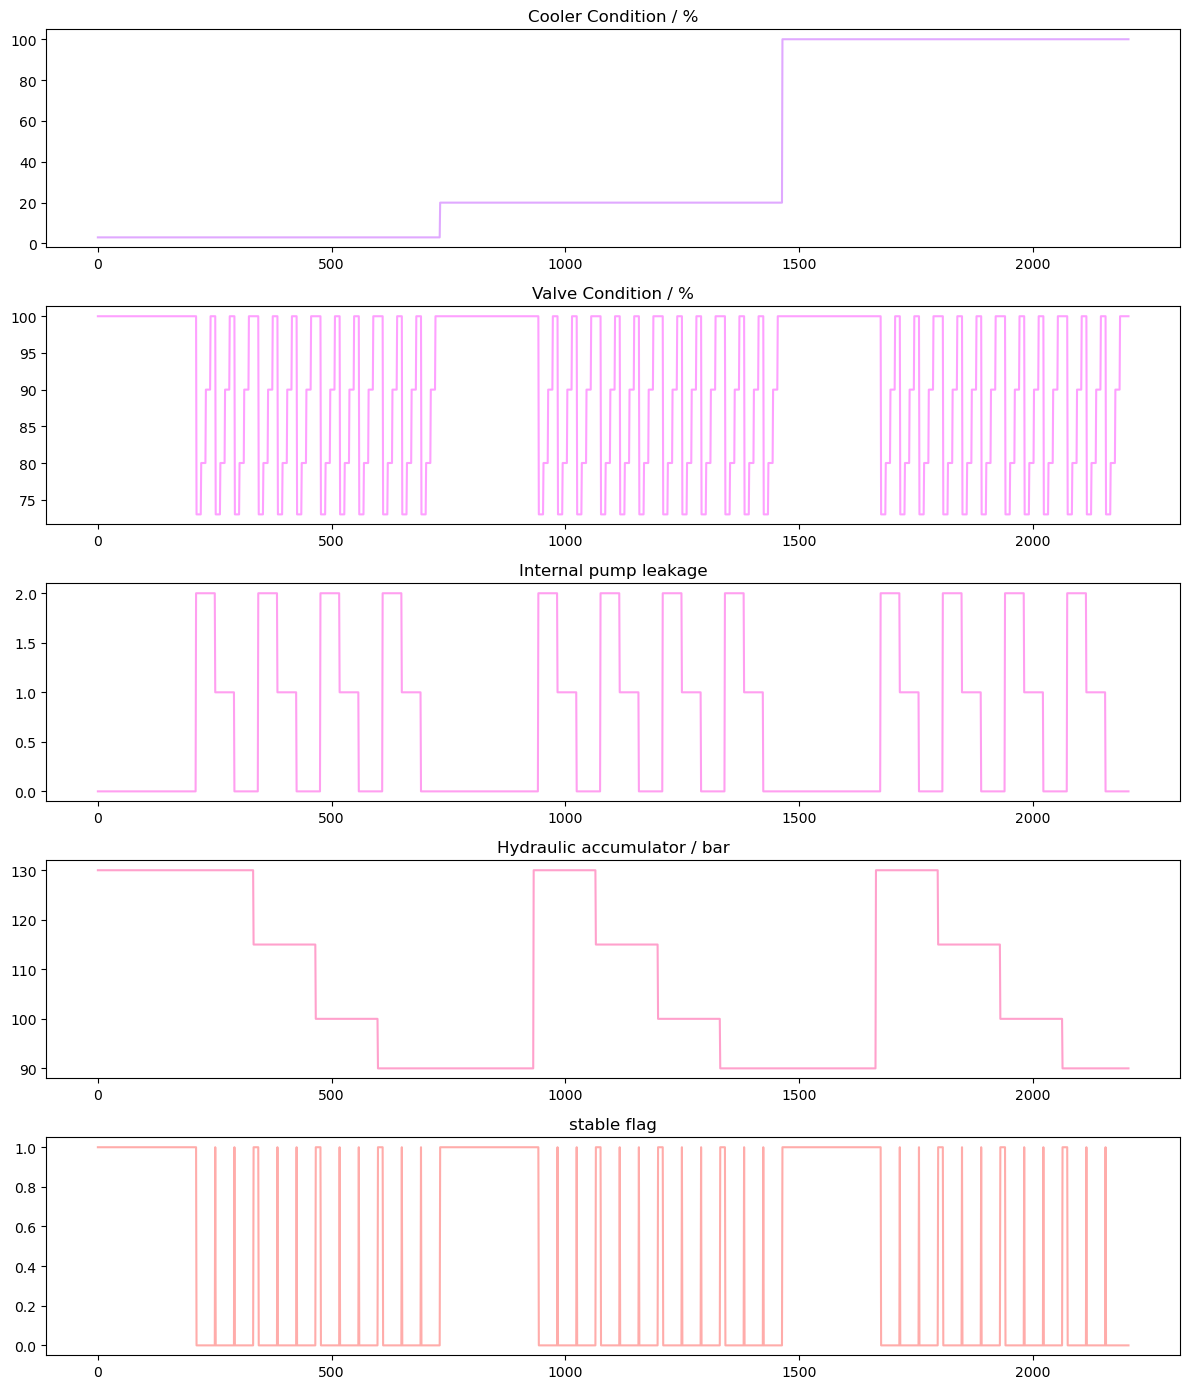

In [9]:
fig, ax = plt.subplots(5, 1, figsize=(12,14), tight_layout='tight')
x_axis = df.index
target_cols = df.columns
for col in range(len(target_cols)):
    ax[col].plot(x_axis, df[target_cols[col]], c=colors[col])
    ax[col].set_title(target_cols[col])
plt.savefig("./images/cycle_routines.png")
plt.show();

## Data Preparation

Each row represents one full cycle and each column represents one sample (in this case 1 second) of readings from the temperatue sensor. To create features from this data we will need to come up with methods for aggregating each row of the sensor data into a single column of data.

##### Raw Table (ex: TS1.txt)
| cycle  |1s |2s |3s |.. |60s|
| :---:  |---|---|---|---|---|
| first: | 0 | 1 | 2 |...|59 |
| second:| 0 | 1 | 2 |...|59 |
|   ...  |...|...|...|...|...|
| last:  | 0 | 1 | 2 |...|59 |


##### Taking the average of each row:
| test     |1s-60s | << |
| :---:    | :---: |:---|
| first:   | avg[0]| << |
| second:  | avg[1]| << |
|   ...    |  ...  | << |
| last:    |avg[-1]| << |

| test   |1s-20s    |21s-40s   |41s-60s   |  << |
| :---:  | :---:    | :---:    | :---:    | :---|
| first: |avg[0][0] |avg[0][1] |avg[0][2] |  << |
| second:|avg[1][0] |avg[1][1] |avg[1][2] |  << |
|   ...  |  ...     |  ...     |  ...     |  << |
| last:  |avg[-1][0]|avg[-1][1]|avg[-1][2]|  << |
 
* If we apply this "pattern" to `TS1.txt` we end up with one feature column: *the mean temperature reading
from the sensor for all cycles*. 
* Repeating this pattern for each table of **sensor data** creates a full feature set of mean readings for
all 17 sensors across each **2205 pump cycles**.

## Modeling

As previously mentioned, the data set includes five target variables – cooler condition, valve condition, internal pump leakage, hydraulic accumulator (hydraulic pressure), and stable flag (stable condition). We determined that each of these target variables were vital to the stakeholder and will likely impact our final recommendation. As a result, several models were created. About two models were created for each target variable. Depending on the variable, utilized, certain features were utilized including simple averages of the 60-second cycle, the average change over the course of the cycle, the average and change every 20-seconds of the cycle, and standard deviation of both the full 60-second cycle and every 20-seconds. To begin, we will utilize a simple logistic regression model. Given the data and the stakeholder’s business problem, it will make most sense to run a grid search on several different model types to determine which produces the highest accuracy.

### Baseline Model

To begin, the baseline model ran a simple logistic regression and included all X-variables and utilized ‘Valve Condition’ as the target variable. Valve Condition, measured as a percentage, includes four classifications – 100 meaning the pump was functioning at optimal switching behavior, 90 meaning there was a small lag, 80 meaning there was a severe lag, and 73 meaning the pump was close to total failure.

In [13]:
run "./baseline_model.py"

./target_variables\Cooler_Condition.pkl
./target_variables\Hydraulic_accumulator_bar.pkl
./target_variables\Internal_pump_leakage.pkl
./target_variables\stable_flag.pkl
./target_variables\Valve_Condition.pkl

Cooler Condition:
score: 0.9969788519637462


Hydraulic Accumulator Bar:
score: 0.5921450151057401


Internal Pump Leakage:
score: 0.9969788519637462


Stable Flag:
score: 0.8459214501510574


Valve Condition:
score: 0.743202416918429



In [14]:
feature_avg = pd.read_pickle('./features/cycle_mean.pkl')
feature_avg.head()

,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,PS6,SE,TS1,TS2,TS3,TS4,VS1
0,39.601350,1.862750,2538.929167,6.709815,10.304592,160.673492,109.466914,1.991475,0.0,9.842169,9.728098,59.157183,35.621983,40.978767,38.471017,31.745250,0.576950
1,25.786433,1.255550,2531.498900,6.715315,10.403098,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,59.335617,36.676967,41.532767,38.978967,34.493867,0.565850
2,22.218233,1.113217,2519.928000,6.718522,10.366250,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,59.543150,37.880800,42.442450,39.631950,35.646150,0.576533
3,20.459817,1.062150,2511.541633,6.720565,10.302678,160.188088,109.064807,1.946575,0.0,9.438827,9.337430,59.794900,38.879050,43.403983,40.403383,36.579467,0.569267
4,19.787017,1.070467,2503.449500,6.690308,10.237750,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,59.455267,39.803917,44.332750,41.310550,37.427900,0.577367


In [15]:
#Set the first model's X and y variables
#Here, we will include all of the columns in our feature averages data frame
base_model_X = pd.read_pickle("./features/cycle_mean.pkl")
base_model_y = pd.read_pickle("./target_variables/Valve_Condition.pkl")

In [16]:
# shuffle and split, stratify keeps target distribution same in train/test
base_model_X_train, base_model_X_test, base_model_y_train, base_model_y_test = train_test_split(base_model_X, 
                                                                                base_model_y, 
                                                                                test_size = 0.15, 
                                                                                random_state = 42)

base_model_steps = [('std_scaler', StandardScaler()),
        ('dec_tree', DecisionTreeClassifier(random_state = 42))]
base_model_pipeline = Pipeline(base_model_steps)
# Train the pipeline (tranformations & predictor)
base_model_pipeline.fit(base_model_X_train, base_model_y_train)
base_model_prediction = base_model_pipeline.predict(base_model_X_test)

In [17]:
base_model_pipe_grid = {'dec_tree__criterion': ['gini', 'entropy'],
                   'dec_tree__max_depth': [2,4,6,8,10,12]}

base_model_gs_pipe = GridSearchCV(estimator = base_model_pipeline, 
                       param_grid = base_model_pipe_grid, scoring = 'precision_micro')

base_model_gs_pipe.fit(base_model_X_train, base_model_y_train);

In [18]:
base_model_gs_pipe.score(base_model_X_test, base_model_y_test)

0.9486404833836858

In [19]:
#Create a list of feature importances
features1 = list(zip(base_model_X_train.columns, 
         base_model_gs_pipe.best_estimator_.named_steps['dec_tree'].feature_importances_))

#Sort the list in descending order
features1.sort(reverse=True, key=lambda x : x[1])
feat, val = [[f for f, v in features1],
             [[v] for f, v in features1]]

#Display the sorted list in a table
display(tabulate(val, headers=["importance"], showindex=feat, tablefmt="html"))

,importance
PS2,0.408505
PS1,0.239325
SE,0.204327
PS5,0.0285996
TS1,0.0255069
PS6,0.0226475
TS2,0.021628
PS4,0.0128051
TS3,0.0108177
VS1,0.00742259


### Multiple Model Testing with Grid Search

As previously mentioned, we are going to perform a grid search on multiple models to determine the highest performing models. For now, we will utilize a simple average of the test cycles as the feature.  Once we’ve determined the top performing models, we can perform grid searches with these models and repeat the process for other combinations of target variables and features.

### First Model:
### Feature, Target Variable: Simple Average, Valve Condition

For our first model, we are utilizing the grid search to evaluate the Valve Condition as our target variable and utilizing the average metrics of each cycle (simple average) as our feature. To begin, we will evaluate five different models – a logistic regression model, a decision tree model, a random forest model, a K-nearest neighbors (KNN) model, a support vector machine model, and an XGBoost model. We will run a grid search for each of these models to evaluate the hyperparameters that will produce the highest accuracy scores. As a reminder, Valve Condition, measured as a percentage, includes four classifications – 100 meaning the pump was functioning at optimal switching behavior, 90 meaning there was a small lag, 80 meaning there was a severe lag, and 73 meaning the pump was close to total failure.

In [20]:
#Create a pipeline for each model type and be sure to scale the data using StandrdScaler()
model1_lr_pipe = Pipeline([('scaler', StandardScaler()),
                    ('lr', LogisticRegression(random_state = 42))])

model1_dtree_pipe = Pipeline([('scaler', StandardScaler()),
                    ('dtree',DecisionTreeClassifier(random_state = 42))])

model1_rf_pipe = Pipeline([('scaler', StandardScaler()),
                    ('rf',RandomForestClassifier(random_state = 42))])

model1_knn_pipe = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier())])

model1_svm_pipe = Pipeline([('scaler', StandardScaler()),
                     ('svm', svm.SVC(random_state = 42))])

model1_xgb_pipe = Pipeline([('scaler', StandardScaler()),
                     ('xgb', XGBClassifier(random_state = 42))])

In [21]:
#Create any paramter ranges that will be utilized in the model grids
model1_param_range = [1, 2, 3, 4, 5, 6]
model1_param_range_fl = [1.0, 0.5, 0.1]
model1_n_estimators = [50, 100, 150]
model1_learning_rates = [.1, .2, .3]

#Create grids with parameters that we would like to use for each model
model1_lr_param_grid = [{'lr__penalty': ['l1', 'l2'],
                   'lr__C': model1_param_range_fl,
                   'lr__solver': ['liblinear']}]

model1_dtree_param_grid = [{'dtree__criterion': ['gini', 'entropy'],
                   'dtree__min_samples_leaf': model1_param_range,
                   'dtree__max_depth': model1_param_range,
                   'dtree__min_samples_split': model1_param_range[1:]}]

model1_rf_param_grid = [{'rf__min_samples_leaf': model1_param_range,
                   'rf__max_depth': model1_param_range,
                   'rf__min_samples_split': model1_param_range[1:]}]

model1_knn_param_grid = [{'knn__n_neighbors': model1_param_range,
                   'knn__weights': ['uniform', 'distance'],
                   'knn__metric': ['euclidean', 'manhattan']}]

model1_svm_param_grid = [{'svm__kernel': ['linear', 'rbf'], 
                    'svm__C': model1_param_range}]

model1_xgb_param_grid = [{'xgb__learning_rate': model1_learning_rates,
                    'xgb__max_depth': model1_param_range,
                    'xgb__min_child_weight': model1_param_range[:2],
                    'xgb__subsample': model1_param_range_fl,
                    'xgb__n_estimators': model1_n_estimators}]

In [22]:
#Create grid searches for each model and set cross validation to 3 and n_jobs to -1 (this will help the models run faster)
model1_lr_grid_search = GridSearchCV(estimator = model1_lr_pipe,
                              param_grid = model1_lr_param_grid,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

model1_dtree_grid_search = GridSearchCV(estimator = model1_dtree_pipe,
                                 param_grid = model1_dtree_param_grid,
                                 scoring = 'accuracy',
                                 cv = 3,
                                 n_jobs = -1)

model1_rf_grid_search = GridSearchCV(estimator = model1_rf_pipe,
                              param_grid = model1_rf_param_grid,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

model1_knn_grid_search = GridSearchCV(estimator = model1_knn_pipe,
                               param_grid = model1_knn_param_grid,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs = -1)

model1_svm_grid_search = GridSearchCV(estimator = model1_svm_pipe,
                               param_grid = model1_svm_param_grid,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs = -1)

model1_xgb_grid_search = GridSearchCV(estimator = model1_xgb_pipe,
                               param_grid = model1_xgb_param_grid,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs = -1)

In [23]:
#Create a list of the grid searches previously put together
grids = [model1_lr_grid_search, 
         model1_dtree_grid_search, 
         model1_rf_grid_search, 
         model1_knn_grid_search, 
         model1_svm_grid_search, 
         model1_xgb_grid_search]

#Create a for loop to fitthe train models
for i in grids:
    i.fit(base_model_X_train, base_model_y_train)

C:\tools\Anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [24]:
#Create a dictionary of each model used
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines', 5: 'XGBoost'}

#Combine the dictionar with the applicable model's best parameters and accuracy scores
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],\
    model.score(base_model_X_test, base_model_y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))
    print('\v')

Logistic Regression Test Accuracy: 0.8700906344410876
Logistic Regression Best Params: {'lr__C': 1.0, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}

Decision Trees Test Accuracy: 0.797583081570997
Decision Trees Best Params: {'dtree__criterion': 'gini', 'dtree__max_depth': 6, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 6}

Random Forest Test Accuracy: 0.8610271903323263
Random Forest Best Params: {'rf__max_depth': 6, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2}

K-Nearest Neighbors Test Accuracy: 0.918429003021148
K-Nearest Neighbors Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}

Support Vector Machines Test Accuracy: 0.9788519637462235
Support Vector Machines Best Params: {'svm__C': 6, 'svm__kernel': 'linear'}

XGBoost Test Accuracy: 0.972809667673716
XGBoost Best Params: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150, 'xgb__subsample': 0.5}



Here we are including confusion matrices to evaluate the false positive and false negative rates for the stakeholder. For this target variable, we will build confusion matrices for the XGB and KNN models.

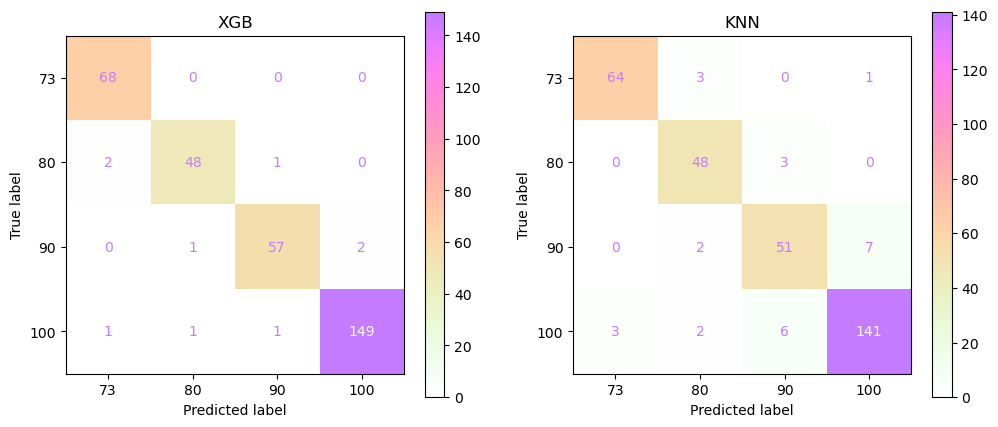

In [25]:
#Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#Have each subplot represent a confusion matrix for each model
plot_confusion_matrix(model1_xgb_grid_search, base_model_X_test, base_model_y_test, cmap=conf_m_colors, ax=ax[0])
plot_confusion_matrix(model1_knn_grid_search, base_model_X_test, base_model_y_test, cmap=conf_m_colors, ax=ax[1])
ax[0].set_title('XGB')
ax[1].set_title('KNN')
plt.savefig("./images/first_model_conf.png")
plt.show()

Lastly, for two models, we will include a summary of scores including the accuracy score, the F-1 weighted score, and the ROC-AUC score. We previously presented the accuracy score however by including the F-1 weighted and ROC-AUC scores, the stakeholder will be able to evaluate the precision and recall through the F-1 weighted score and the classifier’s ability to distinguish between classes through the ROC-AUC score.

In [26]:
#Print all accuracy scores for each model
print(get_accuracy('KNN', model1_knn_grid_search, base_model_X_test, base_model_y_test))
print(get_f1_weighted_score('KNN', model1_knn_grid_search, base_model_X_test, base_model_y_test))
print(get_roc_auc_score('KNN', model1_knn_grid_search, base_model_X_test, base_model_y_test))
print('\v')
print(get_accuracy('XGB', model1_xgb_grid_search, base_model_X_test, base_model_y_test))
print(get_f1_weighted_score('XGB', model1_xgb_grid_search, base_model_X_test, base_model_y_test))
print(get_roc_auc_score('XGB', model1_xgb_grid_search, base_model_X_test, base_model_y_test))

('Accuracy Score: ', 0.918429003021148)
('F-1 Weighted Score: ', 0.9186346493473566)
('ROC-AUC Score: ', 0.9432591283982722)

('Accuracy Score: ', 0.972809667673716)
('F-1 Weighted Score: ', 0.9727442972719881)
('ROC-AUC Score: ', 0.9990739744776906)


## Modeling Iterations

The below iterations will now take the general structure we have laid out above and essentially repeat the process with the balance of the target variables.

### Second Model:

### Feature, Target Variable: Simple Average, Internal Pump Leakage

This second model will again utilize grid search to evaluate the target variable, now Internal Pump and again utilize the simple average as our feature. As a reminder, the Internal Pump Leakage target variable is measured with three classifications includes – 0 meaning no leakage, 1 meaning weak leakage, and 2 meaning severe leakage.

### Grid Search Class / Function

Given we will utilize the grid search on the same five models as previously done, we will create a class function such that the grid searches and modeling are easily reproducible.

```python
class RegularModel:

    def __init__(self, X_path:Union[BinaryIO, str], y_path:Union[BinaryIO, str], X_name:str='', y_name:str='', random_state:int=42, test_size:float=0.15):
        self._X = pd.read_pickle(X_path)
        self._y = pd.read_pickle(y_path)
        self.features = X_name
        self.target = y_name
        self.rs = random_state
        self.test_size = test_size
        self._X_train, self._X_test, self._y_train, self._y_test = train_test_split(self._X, 
                                                                                        self._y, 
                                                                                        test_size = self.test_size, 
                                                                                        random_state = self.rs)

        _knn_pipe = Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsClassifier())])
        
        _xgb_pipe = Pipeline([('scaler', StandardScaler()),
                             ('xgb', XGBClassifier(random_state = self.rs))])

        param_range = [1, 2, 3, 4, 5, 6]
        param_range_fl = [1.0, 0.5, 0.1]
        n_estimators = [50, 100, 150]
        learning_rates = [.1, .2, .3]

        knn_param_grid = [{'knn__n_neighbors': param_range,
                           'knn__weights': ['uniform', 'distance'],
                           'knn__metric': ['euclidean', 'manhattan']}]

        xgb_param_grid = [{'xgb__learning_rate': learning_rates,
                            'xgb__max_depth': param_range,
                            'xgb__min_child_weight': param_range[:2],
                            'xgb__subsample': param_range_fl,
                            'xgb__n_estimators': n_estimators}]

        self.knn_grid_search = GridSearchCV(estimator = _knn_pipe,
                                       param_grid = knn_param_grid,
                                       scoring = 'accuracy',
                                       cv = 3,
                                       n_jobs = -1)

        self.xgb_grid_search = GridSearchCV(estimator = _xgb_pipe,
                                       param_grid = xgb_param_grid,
                                       scoring = 'accuracy',
                                       cv = 3,
                                       n_jobs = -1)
        
        self.grids = [self.knn_grid_search, self.xgb_grid_search]

    def fit_model(self):
        for i in self.grids:
            i.fit(self._X_train, self._y_train)
        return self
    
    def save_model(self, filename:Union[BinaryIO, str]):
        if not isinstance(joblib, Module):
            from joblib import dump
        dump(self, filename)

    def report(self, how:str="print", where:Union[BinaryIO, str]=""):
        grid_dict = {0: 'K-Nearest Neighbors', 1: 'XGBoost'}
        rep_list = []
        rep_list.append(f"Feature type: {self.features}\nTarget Variable: {self.target}\n")
        rep_list.append('\n')
        for i, model in enumerate(self.grids):
            rep_list.append('{} Test Accuracy: {}\n'.format(grid_dict[i],\
            model.score(self._X_test, self._y_test)))
            rep_list.append('{} Best Params: {}\n'.format(grid_dict[i], model.best_params_))
            rep_list.append('\n')
        if how == "file":
            if not where:
                raise ValueError("You must pass a string with filename and path to use 'file' output method.")
            with open(where, 'w') as file:
                file.writelines(rep_list)
                return print(f"Report ouput to {where}.")
        return print(*rep_list)
```

In [27]:
#Load in the X and y variables from the applicable pickle files
model2_X = "./features/cycle_mean.pkl"
model2_y = "./target_variables/Internal_pump_leakage.pkl"

#Load the model using the previously defined function
model2 = RegularModel(model2_X, model2_y, 'Simple Averages', 'Internal Pump Leakage')

#Fit the model using the previously defined function
model2.fit_model()

In [28]:
#Return the summary metrics using our previously defined functions
metric = get_metrics("Model_2", 1, "./models/model_2.joblib")
headers = []
value = []
for header, val in metric:
    headers.append(header)
    value.append([val])
display(tabulate(value, headers=["Model 2"], showindex=headers, tablefmt='html'))

,Model 2
Accuracy Score:,0.987915
ROC-AUC Score:,0.999786
F-1 Weighted Score:,0.987915


In [29]:
#Create a list of feature importances
features2 = list(zip(model2._X_train.columns, 
         model2.grids[1].best_estimator_.named_steps['xgb'].feature_importances_))

#Sort the list in descending order
features2.sort(reverse=True, key=lambda x : x[1])
feat, val = [[f for f, v in features2],
             [[v] for f, v in features2]]

#Display the sorted list in a table
display(tabulate(val, headers=["importance"], showindex=feat, tablefmt="html"))

,importance
SE,0.359089
FS1,0.267551
TS2,0.0642261
EPS1,0.0628446
CP,0.0428683
CE,0.0407903
PS1,0.0382625
FS2,0.033654
PS5,0.0148339
TS1,0.0128708


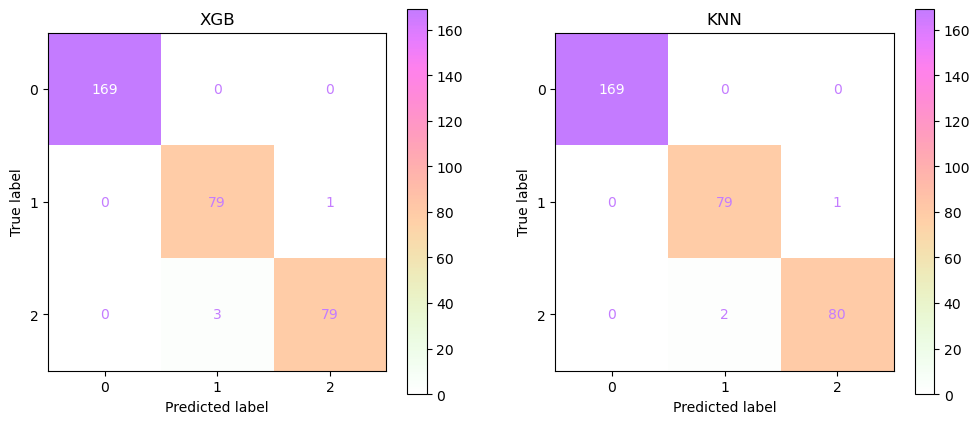

In [30]:
#Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#Have each subplot represent a confusion matrix for each model
plot_confusion_matrix(model2.grids[1], model2._X_test, model2._y_test, cmap=conf_m_colors, ax=ax[0])
plot_confusion_matrix(model2.grids[0], model2._X_test, model2._y_test, cmap=conf_m_colors, ax=ax[1])
ax[0].set_title('XGB')
ax[1].set_title('KNN')
plt.show()

### Third Model:
### Feature, Target Variable: Simple Average, Hydraulic Accumulator / Bar

This third model will again utilize grid search and the class function previously created to evaluate the target variable, Hydraulic Accumulator (pressure) and again utilize the simple average as our feature. Hydraulic Accumulator, measured in bars, includes four classifications – 130 meaning optimal pressure, 115 meaning slightly reduced pressure, 100 meaning severely reduced pressure, and 90 meaning close to failure.

In [31]:
model3_X = "./features/cycle_mean.pkl"
model3_y = "./target_variables/Hydraulic_accumulator_bar.pkl"
model3 = RegularModel(model3_X, model3_y, 'Simple Averages', 'Hydraulic Accumulator / Bar')
model3.fit_model()

In [32]:
model3.report()

Feature type: Simple Averages
Target Variable: Hydraulic Accumulator / Bar
 
 K-Nearest Neighbors Test Accuracy: 0.9637462235649547
 K-Nearest Neighbors Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
 
 XGBoost Test Accuracy: 0.9697885196374623
 XGBoost Best Params: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 4, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150, 'xgb__subsample': 0.5}
 



In [33]:
print(get_accuracy('KNN', model3.grids[0], model3._X_test, model3._y_test))
print(get_f1_weighted_score('KNN', model3.grids[0], model3._X_test, model3._y_test))
print(get_roc_auc_score('KNN', model3.grids[0], model3._X_test, model3._y_test))
print('\v')
print(get_accuracy('XGB', model3.grids[1], model3._X_test, model3._y_test))
print(get_f1_weighted_score('XGB', model3.grids[1], model3._X_test, model3._y_test))
print(get_roc_auc_score('XGB', model3.grids[1], model3._X_test, model3._y_test))

('Accuracy Score: ', 0.9637462235649547)
('F-1 Weighted Score: ', 0.9635651973655772)
('ROC-AUC Score: ', 0.9842895771996268)

('Accuracy Score: ', 0.9697885196374623)
('F-1 Weighted Score: ', 0.9698609457765859)
('ROC-AUC Score: ', 0.9994806072890597)


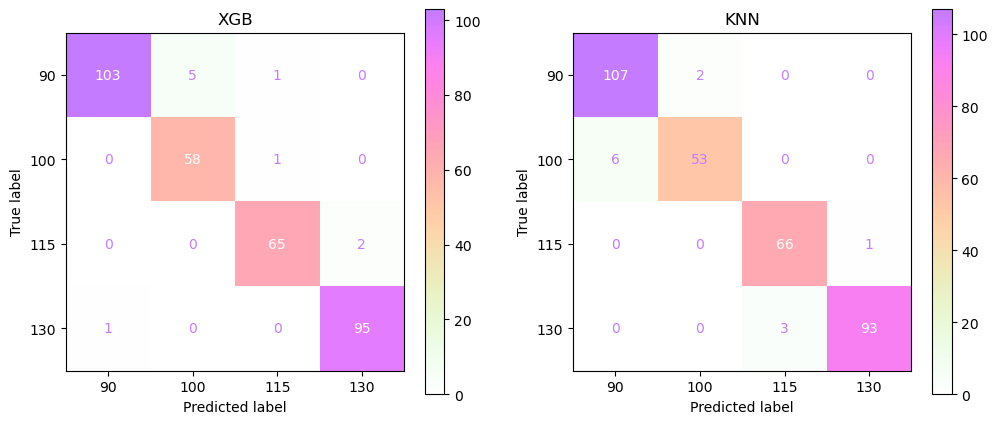

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(model3.grids[1], model3._X_test, model3._y_test, cmap=conf_m_colors, ax=ax[0])
plot_confusion_matrix(model3.grids[0], model3._X_test, model3._y_test, cmap=conf_m_colors, ax=ax[1])
ax[0].set_title('XGB')
ax[1].set_title('KNN')
plt.show()

### Fourth Model:
### Feature, Target Variable: Simple Average, Stable Flag

This fourth model will again utilize grid search, the class function previously and the simple average as our feature. With this model, we will utilize Stable Flag (stability measurement) as the target variable. Unlike the other target variables, Stable Flag only measures two classifications – 0 meaning conditions were stable, and 1 meaning static conditions might not have been reached yet.

In [35]:
model4_X = "./features/cycle_mean.pkl"
model4_y = "./target_variables/stable_flag.pkl"
model4 = RegularModel(model4_X, model4_y, 'Simple Averages', 'Stable Flag')
model4.fit_model()

In [36]:
model4.report()

Feature type: Simple Averages
Target Variable: Stable Flag
 
 K-Nearest Neighbors Test Accuracy: 0.9637462235649547
 K-Nearest Neighbors Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
 
 XGBoost Test Accuracy: 0.9667673716012085
 XGBoost Best Params: {'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150, 'xgb__subsample': 0.5}
 



In [37]:
print(get_accuracy('KNN', model4.grids[0], model4._X_test, model4._y_test))
print(get_f1_weighted_score('KNN', model4.grids[0], model4._X_test, model4._y_test))
print('\v')
print(get_accuracy('XGB', model4.grids[1], model4._X_test, model4._y_test))
print(get_f1_weighted_score('XGB', model4.grids[1], model4._X_test, model4._y_test))

('Accuracy Score: ', 0.9637462235649547)
('F-1 Weighted Score: ', 0.9633435772317546)

('Accuracy Score: ', 0.9667673716012085)
('F-1 Weighted Score: ', 0.9663477541221549)


In [38]:
features4 = list(zip(model4._X_train.columns, 
         model4.grids[1].best_estimator_.named_steps['xgb'].feature_importances_))
features4.sort(reverse=True, key=lambda x : x[1])
feat, val = [[f for f, v in features4],
             [[v] for f, v in features4]]
display(tabulate(val, headers=["importance"], showindex=feat, tablefmt="html"))

,importance
SE,0.222309
PS5,0.188596
PS1,0.101923
FS1,0.075081
CE,0.0555207
PS2,0.045497
FS2,0.0448013
PS6,0.0445329
PS4,0.0436018
TS2,0.0406459


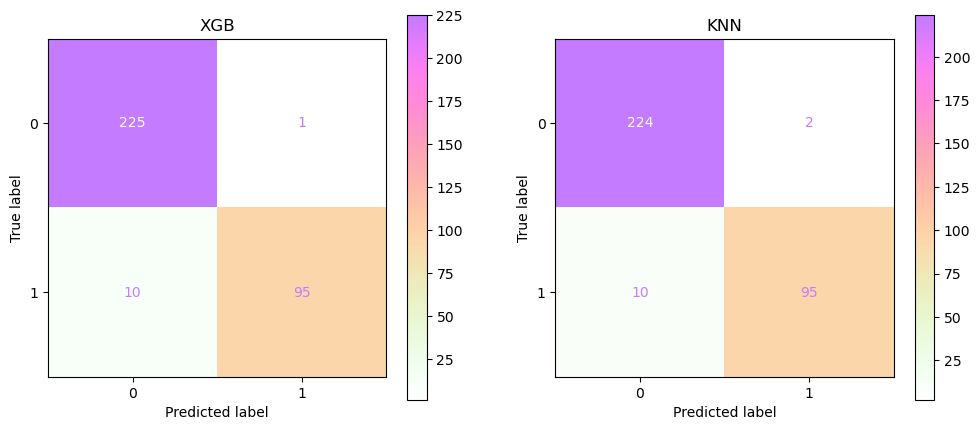

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(model4.grids[1], model4._X_test, model4._y_test, cmap=conf_m_colors, ax=ax[0])
plot_confusion_matrix(model4.grids[0], model4._X_test, model4._y_test, cmap=conf_m_colors, ax=ax[1])
ax[0].set_title('XGB')
ax[1].set_title('KNN')
plt.show()

### Fifth Model:
### Feature, Target Variable: Simple Average, Cooler Condition / %

This fifth model will again utilize grid search, the class function previously and the simple average as our feature. With this model, we will evaluate our last target variable, Cooler Condition as the target variable. Cooler Condition, measured as a percentage, includes three classifications – 100 meaning full efficiency, 20 meaning reduced efficiency, and 3 meaning close to failure.

In [40]:
model5_X = "./features/cycle_mean.pkl"
model5_y = "./target_variables/Cooler_Condition.pkl"
model5 = RegularModel(model5_X, model5_y, 'Simple Averages', 'Cooler Condition / %')
model5.fit_model()

As seen below, it appears our KNN and XGBoost models are reporting perfect scores. This high score is likely being drive by select features that are heavily correlated with our target variable, Cooler Condition.

In [41]:
model5.report()

Feature type: Simple Averages
Target Variable: Cooler Condition / %
 
 K-Nearest Neighbors Test Accuracy: 1.0
 K-Nearest Neighbors Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
 
 XGBoost Test Accuracy: 1.0
 XGBoost Best Params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 1, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150, 'xgb__subsample': 1.0}
 



As noted below, there are about eight characteristics/sensors that have relatively higher correlations with the target variable, Cooler Condition, than others.

In [42]:
features5 = list(zip(model5._X_train.columns, 
         model5.grids[1].best_estimator_.named_steps['xgb'].feature_importances_))
features5.sort(reverse=True, key=lambda x : x[1])
feat, val = [[f for f, v in features5],
             [[v] for f, v in features5]]
display(tabulate(val, headers=["importance"], showindex=feat, tablefmt="html"))

,importance
CE,0.593746
PS2,0.202248
CP,0.191238
PS4,0.00634088
TS4,0.00593607
SE,0.000439237
FS2,2.87687e-05
PS3,2.30741e-05
EPS1,0
FS1,0


### Sixth Model: Second Iteration of the Fifth Model

The sixth and final model for the simple mean feature, will essentially be the fifth model but with the removal of the eight characteristics outlined above.

In [43]:
model6_df = pd.read_pickle(model5_X)

In [44]:
model6_df = model6_df.drop(['CE', 'FS2', 'PS5', 'PS6', 'CP', 'TS1', 'TS4', 'TS2'], axis = 1)
model6_df.to_pickle('./features/model6_dropped_columns.pkl')

```python
model6_X = './features/model6_dropped_columns.pkl'
model6_y = './target_variables/Cooler_Condition.pkl'
model6 = RegularModel(model6_X, model6_y, 'Simple Averages', 'Cooler Condition / %')
model6.fit_model()
```

In [45]:
model6 = load("./models/model_6.joblib")

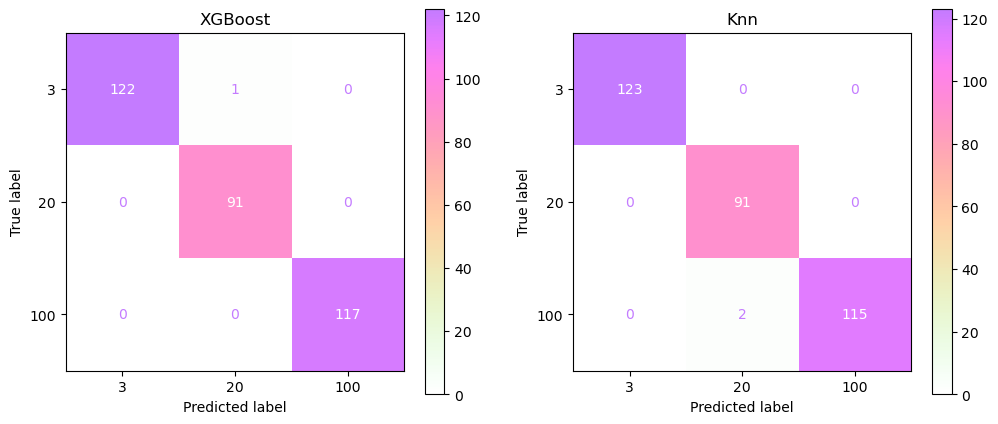

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(model6.grids[1], model6._X_test, model6._y_test, cmap=conf_m_colors, ax=ax[0])
plot_confusion_matrix(model6.grids[0], model6._X_test, model6._y_test, cmap=conf_m_colors, ax=ax[1])
ax[0].set_title("XGBoost")
ax[1].set_title("Knn")
plt.show()

In [47]:
features6 = list(zip(model6._X_train.columns, 
         model6.grids[1].best_estimator_.named_steps['xgb'].feature_importances_))
features6.sort(reverse=True, key=lambda x : x[1])
feat, val = [[f for f, v in features6],
             [[v] for f, v in features6]]
display(tabulate(val, headers=["importance"], showindex=feat, tablefmt="html"))

,importance
PS3,0.352387
EPS1,0.231314
TS3,0.215159
PS2,0.115249
VS1,0.0456344
PS4,0.0282399
SE,0.00932862
FS1,0.00180954
PS1,0.000878686


In [48]:
metric = get_metrics("Model_6", 1, "./models/model_6.joblib")
headers = []
value = []
for header, val in metric:
    headers.append(header)
    value.append([val])
display(tabulate(value, headers=["Model 6"], showindex=headers, tablefmt='html'))

,Model 6
Accuracy Score:,0.996979
ROC-AUC Score:,1
F-1 Weighted Score:,0.996981


## Modeling Other Features

### Looping
Below we are using the previous work we did to loop through the feature sets and target variables. We first fit a model for each combination of features and targets, and then return the test results for each allowing us to compare them and select the best models.

In [49]:
# creating a list of the feature and target sets saved to pickle files
features = [] 
for itm in iglob('./features/*.pkl'):
    filename = os.path.basename(itm)[:-4]
    if filename in ["cond_encoding", "sensor_info"]:
        continue
    features.append((filename, itm)) 
target_vars = [] 
for f_path in iglob("./target_variables/*.pkl"):
    filename = os.path.basename(f_path)[:-4]
    target_vars.append((filename, f_path))

**Above** I am making a list of both the **feature** and the **target** variable files containing their respective data.

**Below** we create a list of arguments to be passed to the `pool_func` operation.

In [50]:
# creating a list of arguments to pass to the model fit loop
args_list = []
for name, path in target_vars:
    for feature, pkl in features:
        args_list.append((pkl, path, feature, name))

### Pool Function
**The below function** uses the `args_list` to loop through our feature and target variable sets and fit a model to each one. It then saves the models to binary pickle files so we can access them later without refitting.

**Lastly** our function outputs the test results for each models as a text file corresponding to the pickled model's name and then returns the time it took to fit and run the model.

In [51]:
def pool_func(args):
    start_t = perf_counter()
    _, _, feature, target = args
    model_inst = RegularModel(*args)
    model_inst.fit_model()
    dump(model_inst, f"./models/{target}_{feature}.pkl")
    log_loc = f"./models/{target}_{feature}.txt"
    model_inst.report("file", where=log_loc)
        
    end_t = perf_counter()
    return (f"Target variable {target} with feature set {feature}", end_t - start_t)

```python
for args in args_list:
     msg, duration = pool_func(args)
     print(f"{msg} took {duration} to compute.")
```

### Results!
**Above** is the loop for our pool function. It is in a markdown code block to prevent it from being run on accident. It takes 20 - 30 minutes to complete and we do not want to save over any of our pickle files unless we decide to explicitly.

**Below** is a print out of our results. From this process we were able to identify the best model/feature/target variable pairings and focus on those for our **final iteration**.

| Target     | Feature                   |   KNN Accuracry |   XGBoost Accuracy |
|   :---:    |          :---:            |      :---:      |        :---:       |
| avg_3rds   | Cooler_Condition          |        1        |           1        |
| avg_change | Cooler_Condition          |        0.924471 |           0.987915 |
| cycle_mean | Cooler_Condition          |        1        |           1        |
| dx_3rds    | Cooler_Condition          |        0.927492 |           0.996979 |
| std_3rds   | Cooler_Condition          |        0.996979 |           0.990937 |
| std_dev    | Cooler_Condition          |        0.990937 |           0.990937 |
| avg_3rds   | Hydraulic_accumulator_bar |        0.963746 |           0.987915 |
| avg_change | Hydraulic_accumulator_bar |        0.818731 |           0.963746 |
| cycle_mean | Hydraulic_accumulator_bar |        0.963746 |           0.969789 |
| dx_3rds    | Hydraulic_accumulator_bar |        0.670695 |           0.942598 |
| std_3rds   | Hydraulic_accumulator_bar |        0.930514 |           0.975831 |
| std_dev    | Hydraulic_accumulator_bar |        0.8429   |           0.915408 |
| avg_3rds   | Internal_pump_leakage     |        0.990937 |           0.996979 |
| avg_change | Internal_pump_leakage     |        0.697885 |           0.854985 |
| cycle_mean | Internal_pump_leakage     |        0.990937 |           0.987915 |
| dx_3rds    | Internal_pump_leakage     |        0.646526 |           0.794562 |
| std_3rds   | Internal_pump_leakage     |        0.92145  |           0.969789 |
| std_dev    | Internal_pump_leakage     |        0.963746 |           0.984894 |
| avg_3rds   | stable_flag               |        0.966767 |           0.963746 |
| avg_change | stable_flag               |        0.827795 |           0.942598 |
| cycle_mean | stable_flag               |        0.963746 |           0.966767 |
| dx_3rds    | stable_flag               |        0.800604 |           0.912387 |
| std_3rds   | stable_flag               |        0.957704 |           0.969789 |
| std_dev    | stable_flag               |        0.954683 |           0.969789 |
| avg_3rds   | Valve_Condition           |        0.984894 |           0.987915 |
| avg_change | Valve_Condition           |        0.465257 |           0.504532 |
| cycle_mean | Valve_Condition           |        0.918429 |           0.97281  |
| dx_3rds    | Valve_Condition           |        0.44713  |           0.483384 |
| std_3rds   | Valve_Condition           |        0.694864 |           0.933535 |
| std_dev    | Valve_Condition           |        0.752266 |           0.960725 |

## Evaluation

After running all of the above models and inspecting their output we determined that **XGBoost** was the best model to iterate one more time. We were also able to determine which feature/target pairings resulted in the best predictions.

**Below** we set up test to see which of the sensors had the best feature importance on average. A series of functions in `helpers.py` were chained along with some search and result parsing to allow us to extract the relevant statistics.

In [52]:
name, avg = get_feature_avg("./features/sensor_info.pkl", "./models/*.pkl", top=5)

In [53]:
x = list(zip(name, avg))
x.sort(reverse=True, key=lambda x : x[1])
zero, one, two, three = [[(zero, avg) for zero, avg in x if len(zero[0]) < 2],
                         [(one, avg) for one, avg in x if one[1] == '1'],
                         [(two, avg) for two, avg in x if two[1] == '2'],
                         [(three, avg) for three, avg in x if three[1] == '3']]

**Above** we are routing the results from a function into separate lists depending on the time series from which the data originated.

**Below** we are splitting it once more to give us our x and y outputs for each time series type. Then we can graph the averages to take a look at our feature importance in a more comprehensive way.

In [54]:
zero_x, zero_y = [[name for name, avg in zero],
                  [avg for name, avg in zero]]
one_x, one_y = [[name[0] for name, avg in one],
                  [avg for name, avg in one]]
two_x, two_y = [[name[0] for name, avg in two],
                  [avg for name, avg in two]]
three_x, three_y = [[name[0] for name, avg in three],
                  [avg for name, avg in three]]

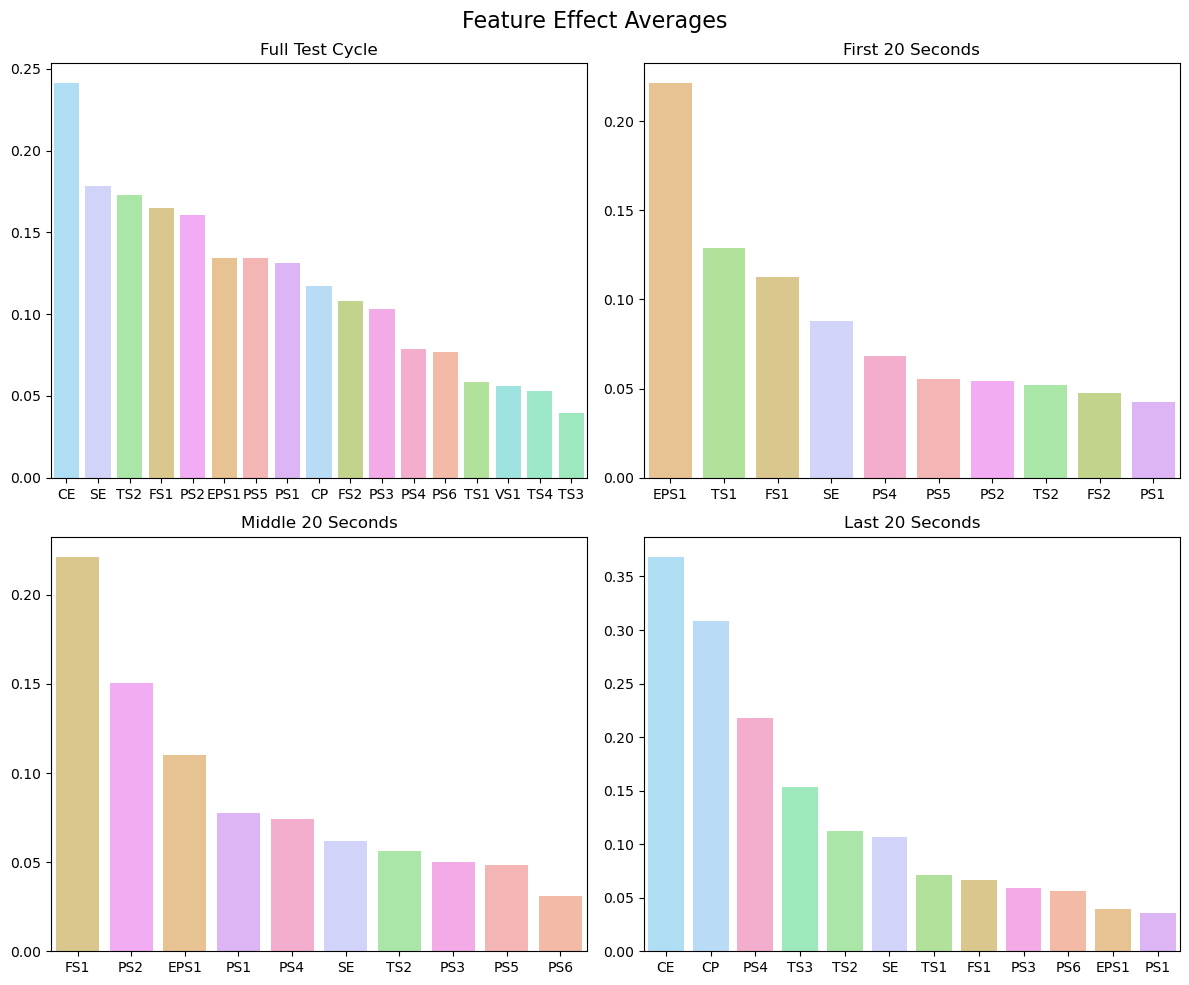

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), tight_layout='tight')
fig.suptitle("Feature Effect Averages", fontsize=16)
ax[0,0].set_title("Full Test Cycle")
ax[0,1].set_title("First 20 Seconds")
ax[1,0].set_title("Middle 20 Seconds")
ax[1,1].set_title("Last 20 Seconds")
sns.barplot(x=zero_x, y=zero_y, palette=color_dict, ax=ax[0,0])
sns.barplot(x=one_x, y=one_y,  palette=color_dict, ax=ax[0,1])
sns.barplot(x=two_x, y=two_y, palette=color_dict, ax=ax[1,0])
sns.barplot(x=three_x, y=three_y, palette=color_dict, ax=ax[1,1])
plt.show()

### Top 8 Sensors
**Below** are the 8 top performing sensors in predicting the state of the hydraulic pump test rig.

<img src="./images/top_sensors.png"/>

### Final Results

**Below** we have the metrics from our final models.

#### XGBoost
We decided to go with the **XGBoost** model for our final iteration and Average of cycle thirds as the feature set for each target variable *except* Cooler Condition. For Cooler Condition we decided to use the Standard Deviation for Cycle 3rds as the feature. This was due to its consistently high score along all our metric axes.

In [56]:
# code here to evaluate your final model

count = 0
final_metrics = []
header = []
value = []
for index in range(len(FINAL_PAIRS)):
    try:
        metrics = get_metrics(FINAL_PAIRS[index], 1, f"./models/{FINAL_PAIRS[index]}.pkl")
    except ValueError:
        pass
    value_row = []
    for text, val in metrics:
        if not count:
            header.append(text)
        value_row.append(val)
    count += 1
    value.append(value_row)
display(tabulate([header, *value], headers='firstrow', showindex=FINAL_PAIRS, tablefmt="html"))

,Accuracy Score:,ROC-AUC Score:,F-1 Weighted Score:
Cooler_Condition_std_3rds,0.990937,0.999956,0.990955
Hydraulic_accumulator_bar_avg_3rds,0.987915,0.999648,0.987899
Internal_pump_leakage_avg_3rds,0.996979,1,0.996979
stable_flag_avg_3rds,0.996979,1,0.996979
Valve_Condition_avg_3rds,0.987915,0.999692,0.987896


## Conclusion:
### Recommendation:
Considering all of the above analysis we would recommend the stakeholder utilize an XGBoost predictive model. According to the numerous models and iterations we ran, the best, most accurate model the stakeholder should utilize is an XGBoost model. Further, to effectively utilize this model, we would recommend utilizing the model to predict a pump’s cooler condition and internal pump leakage. Based on our analysis, these predictive models generated the highest accuracy scores (99%+).
While the accuracy score of these models are high, there are reasons the model may not fully solve the business problem. The data we utilized was ultimately collected from a single test rig, meaning the environment in which this test rig was producing the data analyzed was carefully selected by the test coordinators. Therefore, there could have been situations that caused leaks or other faults with the pumps that were not accounted for, such as human error or other extreme situations.

**Next Steps:**
Further criteria and analyses could yield additional insights to further inform the stakeholder by:
* **Reviewing other testing data.** The stakeholder should consider utilizing a data set in addition to the one that was analyzed. As previously mentioned, although the data set included 2200+ records of testing data, this data was collected from a single test rig. Utilizing data from another test rig could be helpful with re-checking the accuracy of our final model and noting if our findings were consistent.
* **Collecting real-word data.** Another factor the stakeholder should consider is collecting real-world data. It is known that the stakeholder uses specific water pumps with their irrigation systems. As such, the stakeholder should consider setting up a system to collect daily data similar to that of the data set utilized. By doing so, the stakeholder could utilize the final model with the data processed through their irrigation system.
